<a href="https://colab.research.google.com/github/germansuarez017/Sentiment-Analysis-DeepLearningCourse/blob/main/Proyecto_Marvik_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ideas
# usar smote para agregar labels de paises
# buscar otro modelo

In [ ]:
#upgrade library for plotting the confusion matrix
%pip install mlxtend --upgrade

In [4]:
#normalize spanish punctuations
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ('ñ', 'n')
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [5]:
import pandas as pd
import numpy as np
import re
import os
import glob
# this library is needed to read XML files for converting it into CSV
import xml.etree.ElementTree as ET
import shutil
import csv

# Convert xml files into one CSV
# Function that will extract column data for our CSV file
# ET = Element tree is used to parse, navigate, explore and populate xml files
def xml_to_csv(path):
    '''
    Creates a dataframe populated with the XML information
    :param path: path to the folder containing the XML files
    :return: a dataframe with the information from the XML files
    '''
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        
        #checks what type of dataset is
        if 'train' in xml_file[100:]:
          dataset_type = 'train'
        if 'test' in xml_file[100:]:
          dataset_type = 'test'
        if 'dev' in xml_file[100:]:
          dataset_type = 'val'
        
        #checks country
        country = xml_file[117:119]
        
        tree = ET.parse(xml_file)                           # Reads the xml file and initialize the tree
        root = tree.getroot()
        
        for tweet in root.findall('tweet'):
          value = (normalize(tweet.find('content').text),
                   tweet.find('date').text,
                   tweet.find('sentiment')[0][0].text,
                   country,
                   dataset_type
                   )
          xml_list.append(value)
    column_name = ['tweet', 'date', 'sentiment', 'country', 'dataset_type']
    xml_df = pd.DataFrame(xml_list, columns = column_name)
    return xml_df

In [6]:
#converts xml files into csv
path_xml = '/content/drive/MyDrive/Marvik - Deep Learning en la Práctiva/Proyecto Sentiment Analysis/XML files'
df = xml_to_csv(path_xml)

In [7]:
#discard test tweets, they are untagged
df = df[df.dataset_type != 'test']

In [8]:
#converts dataframe to csv
path = '/content/drive/MyDrive/Marvik - Deep Learning en la Práctiva/Proyecto Sentiment Analysis'
# df.to_csv(path + '/' + 'tweetslatinamerica.csv')

In [7]:
#lets stay with only the tweets, sentiment and country
df = df[['tweet', 'sentiment', 'country']]

In [9]:
#discard NEU or NONE tags
df = df[df.sentiment != 'NEU']
df = df[df.sentiment != 'NONE']

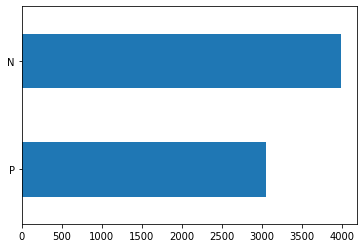

In [10]:
#check how many positive and negative tags are in the dataset
ax = df['sentiment'].value_counts(sort=False).plot(kind='barh')

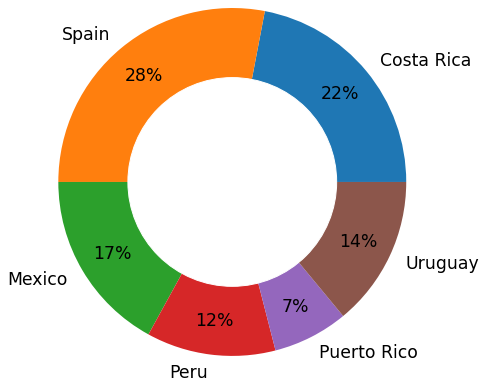

In [11]:
#creates pie chart to see the how many tweets has each country
import matplotlib.pyplot as plt

#group by countries
country_counts = df.groupby(['country'])['country'].count()

#same groupby but in percentage (not used actually)
country_percentage = round((country_counts/country_counts.sum())*100)

#change country names for more suitables
country_percentage.rename(index= {'CR':'Costa Rica', 'ES': 'Spain', 'MX': 'Mexico', 'PE': 'Peru', 'PR': 'Puerto Rico', 'UY':'Uruguay',}, inplace=True)

#get the labels
country_labels = country_percentage.index

# colors=['green', 'blue', 'red', 'yellow', 'orange', 'brown']
#create a circle for the center of the plot
circle = plt.Circle( (0,0), radius = 1.2, color='white')
plt.pie(country_percentage, labels = country_labels, radius = 2, textprops = {'fontsize':'xx-large'}, autopct='%1.0f%%', pctdistance=0.8, labeldistance=1.1)
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

In [12]:
#nltk librería de análisis de lenguaje
import nltk
from nltk.corpus import stopwords

#imports spanish stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('spanish'))

#function to clean tweets
def clean_tweets(tweet):
  #lowercase
  tweet = tweet.lower()
  #removes punctiations
  tweet = re.sub(r'[^a-zA-Z0-9]', ' ', tweet)
  #delete retweets references
  tweet = tweet.replace(' rt ', '')
  #remove stopwords
  tweet = [word for word in tweet.split(sep = ' ') if word not in stopwords]
  
  return (' ').join(tweet)

#apply function to clean text
df['tweet'] = df['tweet'].apply(lambda x: clean_tweets(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


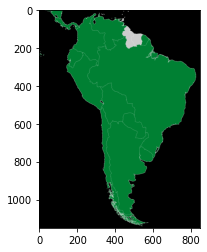

In [13]:
#create mask for worldcloud
import cv2

#reads image and crops it
image = cv2.imread(path + '/latinamericamap.png')
image = image[350:1500, 350:1500]
plt.imshow(image)

True

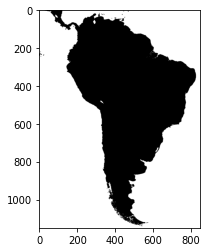

In [14]:
#get mask from the image and saves it for later use
lower = np.array([0,0,0])
upper = np.array([40,255,40])
mask = cv2.inRange(image,lower,upper)
plt.imshow(mask, cmap = 'gray')
cv2.imwrite(img = mask, filename =  path + '/LAmask.jpg')

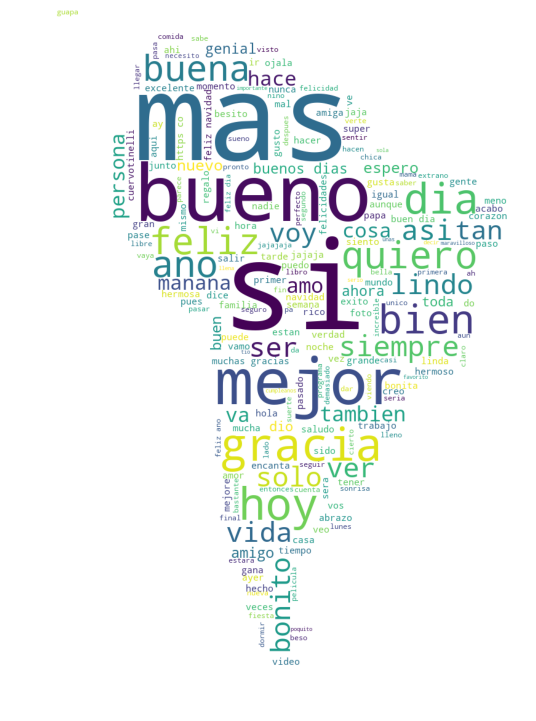

None


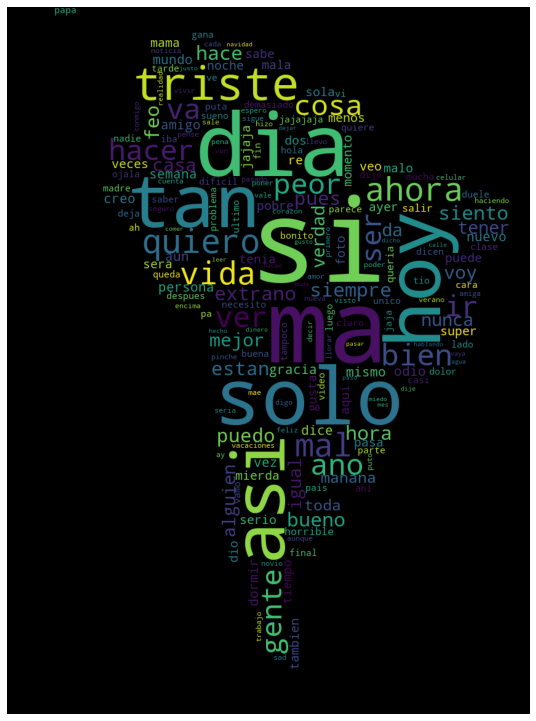

None


In [15]:
#create wordcloud for positive and negative words using mask defined above

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

#creates mask for worldcloud
LAmask = np.array(Image.open(path + '/LAmask.jpg'))

def wordcloud_draw(data, color = 'white'):
  words = ' '.join(data)
  wordcloud = WordCloud(stopwords = stopwords,
                        background_color = color,
                        mask = LAmask
                        ).generate(words)
  plt.figure(1, figsize=(13,13))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

print(wordcloud_draw(df['tweet'][df.sentiment == 'P'], color = 'white'))
print(wordcloud_draw(df['tweet'][df.sentiment == 'N'], color = 'black'))

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

#counts how many words are in the dataset
countvectorizer = CountVectorizer()
countVector = countvectorizer.fit_transform(df['tweet'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))

7037 Number of reviews has 14755 words


In [17]:
#use countvectorizer to create a dataframe with all the words in columns
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countvectorizer.get_feature_names())
count_vect_df.head()

,00,000,0011,0057,00am,02,0211103133,07,095327750,0hmyvolunteer,10,100,1000,102,1080,109,10am,10s,11,111,115,11s,12,120futbol,13,14,143,1477,14m,15,150kmph,15rossonero,16,168,17,1736492,177,178,18,19,...,zamruv,zanaines,zapatillas,zapato,zapdos,zapejuana,zapote,zaragoza,zarcero,zarpados,zavala,zayn,zelda,zepeda,zepol,zero,zeroanima,zeta,zgz,zi,zick,ziempre,zinoscrew,zknowcks7,zoestrange,zombiepolares,zombies,zommix,zona,zonas,zonza,zoo,zorro,zoy,zumbadisimo,zumbido,zumo,zumooo,zunga,zylx
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
#shows most used words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[0:9]

,0
si,653
mas,594
hoy,366
dia,357
gracias,338
mejor,336
quiero,291
feliz,285
solo,283


In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = countVector.shape[1]
#initilize Tokenizer
tokenizer = Tokenizer(num_words = max_features, split =' ')

#training
tokenizer.fit_on_texts(df['tweet'].values)

#transforms tweets in numeric arrays
X1 = tokenizer.texts_to_sequences(df['tweet'].values)

#transforms all sequences into same length
X = pad_sequences(X1)

In [30]:
#prepare train and test dataset
from sklearn.model_selection import train_test_split

#dummies for sentiment
Y = pd.get_dummies(df['sentiment']).values

#train and test separation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

In [31]:
#create validation set with 1000 tweets
validation_size = 500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

In [32]:
#assembling of neural network
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(Y.shape[1], activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 128)           1888640   
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 2,143,834
Trainable params: 2,143,834
Non-trainable params: 0
_________________________________________________________________


In [33]:
#compile and train model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, Y_train, batch_size = 32, epochs = 20, validation_data = (X_validate, Y_validate))

Epoch 1/20
148/148 [==============================] - 20s 111ms/step - loss: 0.6616 - accuracy: 0.5922 - val_loss: 0.5102 - val_accuracy: 0.7820
Epoch 2/20
148/148 [==============================] - 16s 109ms/step - loss: 0.3027 - accuracy: 0.8863 - val_loss: 0.4242 - val_accuracy: 0.8260
Epoch 3/20
148/148 [==============================] - 17s 112ms/step - loss: 0.1190 - accuracy: 0.9542 - val_loss: 0.4330 - val_accuracy: 0.8260
Epoch 4/20
148/148 [==============================] - 16s 109ms/step - loss: 0.0581 - accuracy: 0.9795 - val_loss: 0.5425 - val_accuracy: 0.8140
Epoch 5/20
148/148 [==============================] - 16s 111ms/step - loss: 0.0304 - accuracy: 0.9914 - val_loss: 0.6934 - val_accuracy: 0.8140
Epoch 6/20
148/148 [==============================] - 16s 108ms/step - loss: 0.0165 - accuracy: 0.9958 - val_loss: 0.6061 - val_accuracy: 0.8000
Epoch 7/20
148/148 [==============================] - 16s 106ms/step - loss: 0.0071 - accuracy: 0.9984 - val_loss: 0.8437 - val_ac

In [35]:
#check score and accuracy in test set
score,acc = model.evaluate(X_test, Y_test, batch_size = 32)
print("Score: %.2f" % (score))
print("Acc: %.2f" % (acc))

57/57 [==============================] - 0s 7ms/step - loss: 1.0392 - accuracy: 0.8272
Score: 1.04
Acc: 0.83


In [36]:
import numpy as np
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
    
    if np.argmax(result) == np.argmax(Y_validate[x]):

        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 1s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1

Recall:  0.7800252844500632


<Figure size 432x288 with 0 Axes>

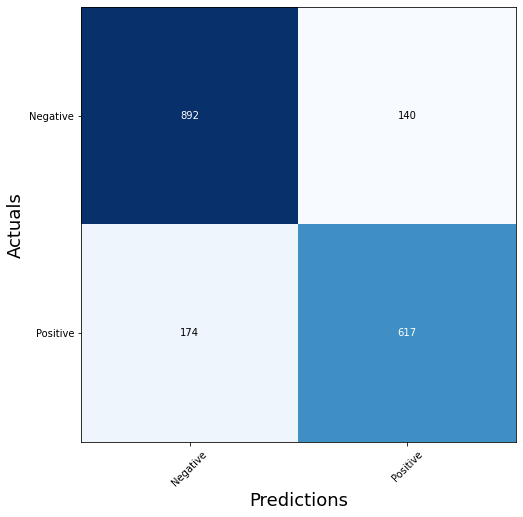

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

y_pred= model.predict(X_test).round()

# calculates confusion matrix
cnf_matrix = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=3)

print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# graph confusion matrix
labels = ['Negative', 'Positive']
plt.figure()
plot_confusion_matrix(conf_mat = cnf_matrix, figsize = (8,8), class_names = labels)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.show()

In [35]:
# =======================================
# COUNTRY PREDICTION
# =======================================

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#exclude puerto rico due to very few samples
df_country = df[df.country != 'PR']

max_features = countVector.shape[1]

#initilize Tokenizer
tokenizer = Tokenizer(num_words = max_features, split =' ')

#training
tokenizer.fit_on_texts(df_country['tweet'].values)

#transforms tweets in numeric arrays
X1_c = tokenizer.texts_to_sequences(df_country['tweet'].values)

#transforms all sequences into same length
X_c = pad_sequences(X1_c)

In [22]:
#instead of predicting the sentiment we ar going to predict the country
from sklearn.model_selection import train_test_split

#dummies for country
Y_c = pd.get_dummies(df_country['country']).values

#train and test separation
X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(X_c, Y_c, test_size = 0.33, random_state = 42)

In [23]:
#create validation set with 1000 tweets
validation_size = 500

X_validate_c = X_test_c[-validation_size:]
Y_validate_c = Y_test_c[-validation_size:]
X_test_c = X_test_c[:-validation_size]
Y_test_c = Y_test_c[:-validation_size]

In [24]:
#assembling of neural network
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embed_dim = 128
lstm_out = 196

model_country = Sequential()
model_country.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_c.shape[1]))
model_country.add(Dropout(0.5))
model_country.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))
model_country.add(Dense(Y_c.shape[1], activation = 'softmax'))
model_country.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22, 128)           1888640   
_________________________________________________________________
dropout (Dropout)            (None, 22, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 5)                 985       
Total params: 2,144,425
Trainable params: 2,144,425
Non-trainable params: 0
_________________________________________________________________


In [25]:
#compile and train model
model_country.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_country.fit(X_train_c, Y_train_c, batch_size = 32, epochs = 20, validation_data = (X_validate_c, Y_validate_c))

Epoch 1/20
138/138 [==============================] - 35s 111ms/step - loss: 1.5796 - accuracy: 0.2947 - val_loss: 1.5836 - val_accuracy: 0.2720
Epoch 2/20
138/138 [==============================] - 15s 110ms/step - loss: 1.3110 - accuracy: 0.4693 - val_loss: 1.2625 - val_accuracy: 0.4840
Epoch 3/20
138/138 [==============================] - 15s 112ms/step - loss: 0.7158 - accuracy: 0.7437 - val_loss: 1.2298 - val_accuracy: 0.5540
Epoch 4/20
138/138 [==============================] - 15s 106ms/step - loss: 0.3598 - accuracy: 0.8818 - val_loss: 1.2314 - val_accuracy: 0.5940
Epoch 5/20
138/138 [==============================] - 14s 103ms/step - loss: 0.1797 - accuracy: 0.9476 - val_loss: 1.3004 - val_accuracy: 0.5840
Epoch 6/20
138/138 [==============================] - 14s 104ms/step - loss: 0.0869 - accuracy: 0.9742 - val_loss: 1.4718 - val_accuracy: 0.6020
Epoch 7/20
138/138 [==============================] - 15s 111ms/step - loss: 0.0537 - accuracy: 0.9870 - val_loss: 1.6392 - val_ac

In [26]:
#check score and accuracy in test set
score_c,acc_c = model_country.evaluate(X_test_c, Y_test_c, batch_size = 32)
print("Score: %.2f" % (score_c))
print("Acc: %.2f" % (acc_c))

53/53 [==============================] - 0s 7ms/step - loss: 2.0588 - accuracy: 0.5825
Score: 2.06
Acc: 0.58


In [27]:
import numpy as np
cr, es, mx, pe, uy = 0, 0, 0, 0, 0
cr_cnt, es_cnt, mx_cnt, pe_cnt, uy_cnt = 0, 0, 0, 0, 0

for x in range(len(X_validate_c)):
    
    result = model_country.predict(X_test_c[x].reshape(1,X_test_c.shape[1]),batch_size=1,verbose = 2)[0]

    if np.argmax(result) == np.argmax(Y_test_c[x]):

        if np.argmax(Y_test_c[x]) == 0:
          cr += 1
        if np.argmax(Y_test_c[x]) == 1:
          es +=1
        if np.argmax(Y_test_c[x]) == 2:
          mx +=1
        if np.argmax(Y_test_c[x]) == 3:
          pe +=1
        if np.argmax(Y_test_c[x]) == 4:
          uy +=1

    if np.argmax(Y_test_c[x]) == 0:
      cr_cnt += 1
    if np.argmax(Y_test_c[x]) == 1:
      es_cnt += 1
    if np.argmax(Y_test_c[x]) == 2:
      mx_cnt += 1
    if np.argmax(Y_test_c[x]) == 3:
      pe_cnt += 1
    if np.argmax(Y_test_c[x]) == 4:
      uy_cnt += 1
    

print("costa rica_acc", round(cr/cr_cnt*100,1), "%")
print("spain_acc", round(es/es_cnt*100,1), "%")
print("mexico_acc", round(mx/mx_cnt*100,1), "%")
print("peru_acc", round(pe/pe_cnt*100,1), "%")
print("uruguay_acc", round(uy/uy_cnt*100,1), "%")


1/1 - 1s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1

<Figure size 432x288 with 0 Axes>

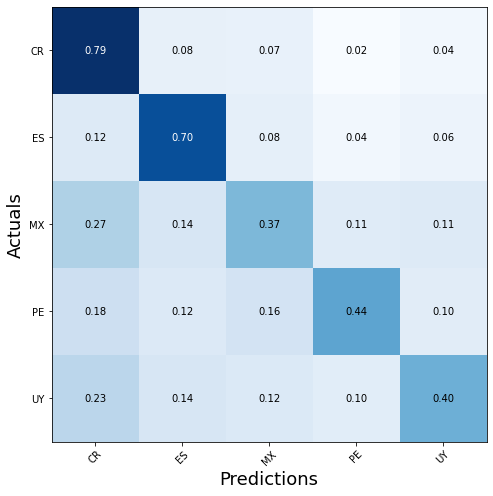

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

y_pred= model_country.predict(X_test_c).round()

# calculates confusion matrix
cnf_matrix = confusion_matrix(Y_test_c.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=3)

# print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# graph confusion matrix
labels = ['CR', 'ES', 'MX', 'PE', 'UY']
plt.figure()
plot_confusion_matrix(conf_mat = cnf_matrix, figsize = (8,8), class_names = labels, show_absolute = False, show_normed = True)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.show()